# Sistemas de recomendacion

## Carga de datos

In [61]:
import pandas as pd

In [127]:
df = pd.read_csv("../datasets/ml-100k/u.data.csv", sep="\t", header=None)

In [128]:
df.head()

,0,1,2,3
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [129]:
df.shape

(100000, 4)

In [130]:
df.columns = ["UserID", "MovieID", "Raiting", "Timestmap"]

In [131]:
df.head()

,UserID,MovieID,Raiting,Timestmap
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596







## Análisis exploratorio de los ítems

In [132]:
import matplotlib.pyplot as plt

### Distribución de valoraciones por usuarios

(array([ 6110.,     0., 11370.,     0.,     0., 27145.,     0., 34174.,
            0., 21201.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

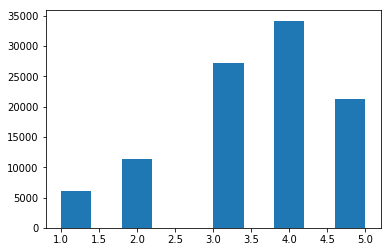

In [237]:
plt.hist(df.Raiting)

In [134]:
df.groupby(["Raiting"])["UserID"].count()

Raiting
1     6110
2    11370
3    27145
4    34174
5    21201
Name: UserID, dtype: int64

### Distribución de películas en el dataset

(array([1.146e+03, 2.490e+02, 1.390e+02, 6.700e+01, 3.800e+01, 2.400e+01,
        7.000e+00, 5.000e+00, 6.000e+00, 1.000e+00]),
 array([  1. ,  59.2, 117.4, 175.6, 233.8, 292. , 350.2, 408.4, 466.6,
        524.8, 583. ]),
 <a list of 10 Patch objects>)

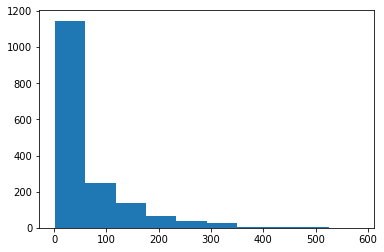

In [236]:
plt.hist(df.groupby(["MovieID"])["MovieID"].count())

### Representación en forma matricial

In [238]:
import numpy as np

In [239]:
n_users = df.UserID.max()
n_users

943

In [240]:
n_movies = df.MovieID.max()
n_movies

1682

In [241]:
ratings = np.zeros((n_users, n_movies))

In [242]:
for row in df.itertuples():
    ratings [row[1]-1, row[2]-1] = row[3]

In [243]:
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [244]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print("Coeficiente de sparseidad: {:4.2f}%".format(sparsity))

Coeficiente de sparseidad: 6.30%


### Crear conjunto de entrenamiento y validación

In [143]:
from sklearn.cross_validation import train_test_split

In [144]:
ratings_train, ratings_test = train_test_split(ratings, test_size = 0.3)

In [145]:
ratings_train.shape[0]

660

### Filtrando con los K nearest neighbors

In [146]:
from sklearn.neighbors import NearestNeighbors
import sklearn as sk

In [147]:
k = 10

In [148]:
neighbors = NearestNeighbors(k, 'cosine')

In [149]:
neighbors.fit(ratings_train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=10, p=2,
         radius='cosine')

In [150]:
top_k_distances, top_k_users = neighbors.kneighbors(ratings_train, return_distance=True)

In [151]:
top_k_distances.shape

(660, 10)

In [152]:
top_k_distances[0]

array([ 0.        , 20.51828453, 21.77154106, 24.95996795, 25.45584412,
       25.47547841, 25.49509757, 25.51470164, 25.65151068, 25.8069758 ])

In [153]:
top_k_users.shape

(660, 10)

In [154]:
top_k_users[0]

array([  0, 307, 423, 221,  67,  92, 385, 386, 333, 304])

### Ponderar todas las valoraciones de los usuarios más cercanos

In [155]:
users_predicts_k = np.zeros(ratings_train.shape) #Se crear una matriz de ceros

#### Predecir pares user-movie

In [156]:
for i in range(ratings_train.shape[0]): #para cada usuario del conjunto 
    users_predicts_k[i,:] = top_k_distances[i].T.dot(ratings_train[top_k_users][i])/np.array([np.abs(top_k_distances[i].T).sum(axis=0)]).T

#### Usar una función que calcula el error cuadratico medio
##### En estadística, el error cuadrático medio (ECM) de un estimador mide el promedio de los errores al cuadrado, es decir, la diferencia entre el estimador y lo que se estima

In [157]:
def get_mse(preds, actuals):
    if preds.shape[0] != actuals.shape[0]:
        actuals = actuals.T
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return sk .metrics.mean_squared_error(preds, actuals)

#### Calcular el ECM

In [158]:
get_mse(users_predicts_k, ratings_train) #Con la matriz de entrenamiento

8.320775259046227

In [160]:
get_mse(users_predicts_k, ratings_test) #Con la matriz de prueba

IndexError: index 660 is out of bounds for axis 0 with size 660

### Filtro colaborativo de los KNN - basado en items

In [176]:
k = 10
neighbors = NearestNeighbors(k, 'cosine')
neighbors.fit(ratings_train.T)
top_k_distances, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance=True)

In [177]:
top_k_items

array([[   0,  120,  116, ...,  221,   94,   27],
       [   1,  232,  553, ..., 1227,  577,   79],
       [   2,  939, 1106, ...,  742,  554, 1323],
       ...,
       [1679, 1606,  909, ...,  676,  851,  598],
       [1680, 1350, 1671, ...,  813,  910,  598],
       [1681,  912,  991, ...,  829,  676,  598]])

#### Predicción basado en los items más cercanos

In [178]:
preds = np.zeros(ratings_train.T.shape)
for i in range(ratings_train.T.shape[0]):
    preds[i, :] = top_k_distances[i].dot(ratings_train.T[top_k_items][i])/np.array([np.abs(top_k_distances[i]).sum(axis=0)]).T

/home/davian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [179]:
get_mse(preds, ratings_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [180]:
get_mse(preds, ratings_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### Análisis de resultados 

#### Predicciones basado en usuarios

In [215]:
dfResultUsersPreds = pd.DataFrame(columns=["UserID", "MovieID", "Raiting"])

In [226]:
rows = []
columns=["UserID", "MovieID", "Raiting"]
for i in range(users_predicts_k.shape[0]):
    for k in range(users_predicts_k.shape[1]):
        row = [i, k , users_predicts_k[i][k]]
        rows.append(row)
dfResultUsersPreds = pd.DataFrame(rows, columns=columns) ## Se convierte la matriz en un dataframe
dfResultUsersPreds = dfResultUsersPreds[dfResultUsersPreds['Raiting'] >= 1]

(array([12734.,  8548.,  4670.,  4128.,  2642.,  1793.,  1334.,   631.,
          368.,    74.]),
 array([1.0000014 , 1.40000126, 1.80000112, 2.20000098, 2.60000084,
        3.0000007 , 3.40000056, 3.80000042, 4.20000028, 4.60000014,
        5.        ]),
 <a list of 10 Patch objects>)

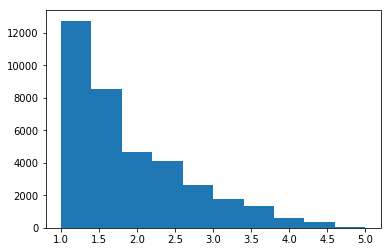

In [227]:
plt.hist(dfResultUsersPreds.Raiting)

(array([618., 113.,  48.,  29.,   9.,   5.,   4.,   3.,   3.,   1.]),
 array([  1. ,  53.9, 106.8, 159.7, 212.6, 265.5, 318.4, 371.3, 424.2,
        477.1, 530. ]),
 <a list of 10 Patch objects>)

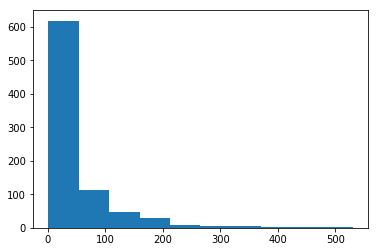

In [234]:
plt.hist(dfResultUsersPreds.groupby(["MovieID"])["MovieID"].count())

#### Predicciones basado en items

In [228]:
dfResultItemsPreds = pd.DataFrame(columns=["UserID", "MovieID", "Raiting"])

In [231]:
rows = []
columns=["UserID", "MovieID", "Raiting"]
for i in range(preds.shape[0]):
    for k in range(preds.shape[1]):
        row = [k, i , preds[i][k]]
        rows.append(row)
dfResultItemsPreds = pd.DataFrame(rows, columns=columns) ## Se convierte la matriz en un dataframe
dfResultItemsPreds = dfResultItemsPreds[dfResultItemsPreds['Raiting'] >= 1]

(array([9841., 7732., 4622., 4098., 3058., 2119., 1639.,  836.,  515.,
         148.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

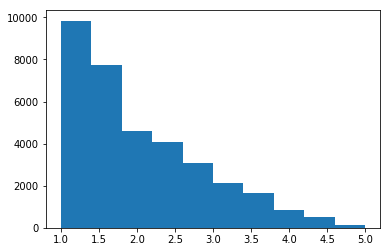

In [232]:
plt.hist(dfResultItemsPreds.Raiting)

(array([984.,  67.,  52.,  36.,  16.,  22.,  13.,   5.,   1.,   3.]),
 array([  1. ,  41.5,  82. , 122.5, 163. , 203.5, 244. , 284.5, 325. ,
        365.5, 406. ]),
 <a list of 10 Patch objects>)

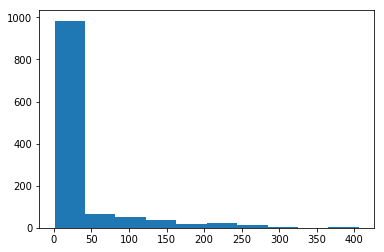

In [233]:
plt.hist(dfResultItemsPreds.groupby(["MovieID"])["MovieID"].count())